
# 🌱 Análisis de Cambios de Vegetación con Sentinel-2 (La Palma, 2021)

Este notebook muestra cómo detectar **cambios de vegetación** antes y después de la **erupción volcánica de Cumbre Vieja (Islas Canarias, 2021)** utilizando datos **Sentinel-2 L2A** del programa **Copernicus**.

Aprenderás a:
1. Descargar imágenes Sentinel-2 mediante la API de Sentinel Hub.
2. Calcular el índice NDVI.
3. Visualizar el cambio de vegetación (ΔNDVI) entre dos fechas.



## 🧩 1. Instalación de dependencias

Primero instalá el paquete `sentinelhub`, que permite acceder a los datos del programa Copernicus directamente desde Python.


In [ ]:
# !pip install sentinelhub
# !pip install ipywidgets tqdm
# !jupyter nbextension enable --py widgetsnbextension


Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK



## 🔑 2. Configuración de credenciales

Necesitás crear una cuenta gratuita en [Sentinel Hub Dashboard](https://apps.sentinel-hub.com/dashboard) y generar un **Client ID** y **Client Secret**.

> User Setttings -> OAuth clients 

Luego, completá las credenciales en el siguiente bloque de código.


In [1]:

from sentinelhub import SHConfig

config = SHConfig()
config.sh_client_id = "9ab4327b-7469-474c-b223-bfed37889bf6"
config.sh_client_secret = "3I8PhC9fwBbotgnOwAnk38y0b4nSy3fV"



## 🌋 3. Definir la zona de estudio: La Palma (Cumbre Vieja)

Seleccionamos un área pequeña alrededor del cono volcánico, donde el contraste antes y después de la erupción es muy marcado.


In [2]:
from sentinelhub import BBox, CRS, SentinelHubCatalog, DataCollection

# 🗺️ Área: mitad sur de La Palma, incluyendo coladas hacia la costa
bbox = BBox(
    bbox=[-18.00, 28.45, -17.75, 28.75],
    crs=CRS.WGS84
)

# ⚙️ Función para buscar la mejor imagen (menor cobertura nubosa)
catalog = SentinelHubCatalog(config=config)

def find_best_image(bbox, time_interval):
    search_iterator = catalog.search(
        DataCollection.SENTINEL2_L2A,
        bbox=bbox,
        time=time_interval,
        fields={"include": ["id", "properties.datetime", "properties.eo:cloud_cover"], "exclude": []},
        limit=50
    )
    results = list(search_iterator)
    if not results:
        raise ValueError(f"No se encontraron imágenes entre {time_interval}")
    
    # Ordenar por menor porcentaje de nubes
    results.sort(key=lambda x: x["properties"]["eo:cloud_cover"])
    best = results[0]
    print(f"🛰️ Imagen seleccionada entre {time_interval}:")
    print("Fecha:", best["properties"]["datetime"])
    print("Cobertura nubosa:", best["properties"]["eo:cloud_cover"], "%")
    return best["properties"]["datetime"][:10]  # YYYY-MM-DD

# 🔍 Buscar mejores imágenes antes y después de la erupción
best_before = find_best_image(bbox, ("2021-08-01", "2021-08-25"))  # vegetación sana
best_after  = find_best_image(bbox, ("2021-12-10", "2021-12-30"))  # post-erupción

# ⏰ Asignar fechas seleccionadas automáticamente
time_before = (best_before, best_before)
time_after  = (best_after, best_after)

print("\n✅ Fechas finales seleccionadas:")
print("Antes:", time_before)
print("Después:", time_after)

🛰️ Imagen seleccionada entre ('2021-08-01', '2021-08-25'):
Fecha: 2021-08-21T12:03:46Z
Cobertura nubosa: 0.0 %
🛰️ Imagen seleccionada entre ('2021-12-10', '2021-12-30'):
Fecha: 2021-12-14T12:03:34Z
Cobertura nubosa: 0.29 %

✅ Fechas finales seleccionadas:
Antes: ('2021-08-21', '2021-08-21')
Después: ('2021-12-14', '2021-12-14')



## 🛰️ 4. Descarga de imágenes Sentinel-2 L2A

Descargamos las bandas necesarias para NDVI:
- **B04 (Rojo)**  
- **B08 (Infrarrojo cercano)**

La resolución será de **10 m/píxel**.


In [3]:
from sentinelhub import (
    SentinelHubRequest, MimeType, DataCollection, bbox_to_dimensions
)
import numpy as np
import matplotlib.pyplot as plt
import os

# Crear carpeta de salida si no existe
os.makedirs("./data", exist_ok=True)

resolution = 30  # metros por píxel
size = bbox_to_dimensions(bbox, resolution=resolution)

def get_image(time_interval):
    request = SentinelHubRequest(
        data_folder="./data",
        evalscript="""
        //VERSION=3
        function setup() {
          return {
            input: ["B04", "B08"],
            output: { bands: 2, sampleType: "FLOAT32" }
          };
        }
        function evaluatePixel(sample) {
          return [sample.B04, sample.B08];
        }
        """,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.SENTINEL2_L2A,
                time_interval=time_interval,
                mosaicking_order='leastCC'  # ✅ preferir menos nubes
            )
        ],
        responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
        bbox=bbox,
        size=size,
        config=config
    )
    return request.get_data(save_data=True)[0]

# Descarga automática usando las mejores fechas detectadas
img_before = get_image(time_before)
img_after  = get_image(time_after)

b4_before, b8_before = img_before[..., 0], img_before[..., 1]
b4_after,  b8_after  = img_after[..., 0],  img_after[..., 1]


## 🌿 6. Cálculo del NDVI y del ΔNDVI

El **NDVI** (Normalized Difference Vegetation Index) se calcula como:

\[ NDVI = \frac{NIR - RED}{NIR + RED} \]

El cambio en vegetación se obtiene como:

\[ \Delta NDVI = NDVI_{después} - NDVI_{antes} \]


In [4]:

def ndvi(b8, b4):
    return (b8 - b4) / (b8 + b4 + 1e-6)

ndvi_before = ndvi(b8_before, b4_before)
ndvi_after  = ndvi(b8_after,  b4_after)
delta_ndvi  = ndvi_after - ndvi_before



## 🖼️ 7. Visualización de los resultados

Mostramos los mapas de NDVI antes, después y el cambio ΔNDVI.


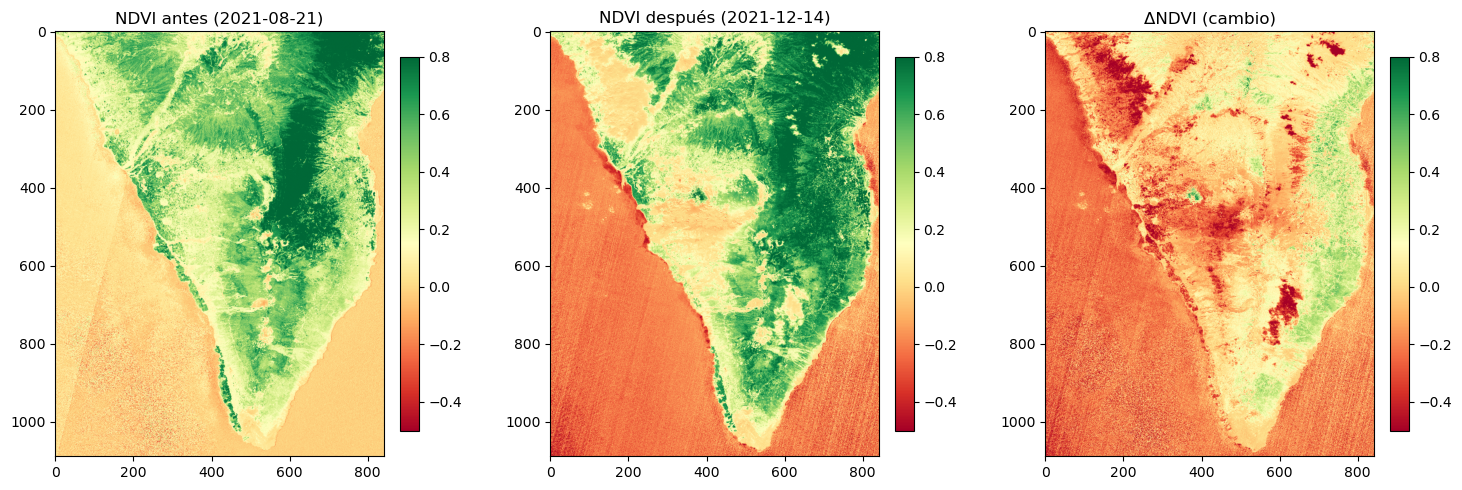

In [5]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

titles = [
    f"NDVI antes ({time_before[0]})",
    f"NDVI después ({time_after[0]})",
    "ΔNDVI (cambio)"
]

for ax, img, title in zip(axs, [ndvi_before, ndvi_after, delta_ndvi], titles):
    im = ax.imshow(img, cmap='RdYlGn', vmin=-0.5, vmax=0.8)
    ax.set_title(title)
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


## 🧭 8. Interpretación

- Los tonos **verdes** indican vegetación sana.  
- Los **rojos o marrones** reflejan pérdida de cobertura vegetal.  
- En el mapa de **ΔNDVI**, los valores **negativos intensos** marcan zonas afectadas por lava y ceniza tras la erupción.

Este análisis puede adaptarse fácilmente a otros eventos (incendios, sequías o deforestación) modificando las coordenadas y fechas.


## 9. Evolución

Una erupción en la dorsal volcánica Cumbre Vieja, que comprende la mitad sur de la isla española de La Palma en las Islas Canarias, tuvo lugar entre el 19 de septiembre y el 13 de diciembre de 2021.

In [6]:
from sentinelhub import BBox, CRS, SentinelHubCatalog, DataCollection

# 🗺️ Zona centrada en el cono y coladas (evita el mar)
bbox = BBox(
    bbox=[-17.93, 28.53, -17.80, 28.64],
    crs=CRS.WGS84
)

catalog = SentinelHubCatalog(config=config)

def find_best_image(bbox, time_interval):
    search_iterator = catalog.search(
        DataCollection.SENTINEL2_L2A,
        bbox=bbox,
        time=time_interval,
        fields={"include": ["properties.datetime", "properties.eo:cloud_cover"], "exclude": []},
        limit=30
    )
    results = list(search_iterator)
    if not results:
        raise ValueError(f"No se encontraron imágenes entre {time_interval}")
    results.sort(key=lambda x: x["properties"]["eo:cloud_cover"])
    best = results[0]["properties"]
    print(f"🛰️ {time_interval}: {best['datetime']} (nubes: {best['eo:cloud_cover']}%)")
    return best["datetime"][:10]

# 🔍 Buscar fechas en ventanas cortas (mitad de cada mes)
best_jul = find_best_image(bbox, ("2021-07-10", "2021-07-20"))
best_aug = find_best_image(bbox, ("2021-08-10", "2021-08-20"))
best_sep = find_best_image(bbox, ("2021-09-10", "2021-09-20"))
best_oct = find_best_image(bbox, ("2021-10-10", "2021-10-20"))
best_nov = find_best_image(bbox, ("2021-11-10", "2021-11-20"))
best_dec = find_best_image(bbox, ("2021-12-10", "2021-12-20"))
best_jan = find_best_image(bbox, ("2022-01-10", "2022-01-20"))
best_feb = find_best_image(bbox, ("2022-02-10", "2022-02-20"))

# --- Para el bloque NDVI ---
time_jul = (best_jul, best_jul)
time_aug = (best_aug, best_aug)
time_sep = (best_sep, best_sep)
time_oct = (best_oct, best_oct)
time_nov = (best_nov, best_nov)
time_dec = (best_dec, best_dec)
time_jan = (best_jan, best_jan)
time_feb = (best_feb, best_feb)

print("\n✅ Fechas seleccionadas:")
print("Jul:", best_jul)
print("Ago:", best_aug)
print("Sep:", best_sep)
print("Oct:", best_oct)
print("Nov:", best_nov)
print("Dic:", best_dec)
print("Ene:", best_jan)
print("Feb:", best_feb)

🛰️ ('2021-07-10', '2021-07-20'): 2021-07-17T12:03:46Z (nubes: 1.01%)
🛰️ ('2021-08-10', '2021-08-20'): 2021-08-16T12:03:43Z (nubes: 0.11%)
🛰️ ('2021-09-10', '2021-09-20'): 2021-09-10T12:03:44Z (nubes: 0.79%)
🛰️ ('2021-10-10', '2021-10-20'): 2021-10-15T12:03:45Z (nubes: 2.97%)
🛰️ ('2021-11-10', '2021-11-20'): 2021-11-19T12:03:44Z (nubes: 0.46%)
🛰️ ('2021-12-10', '2021-12-20'): 2021-12-14T12:03:34Z (nubes: 0.29%)
🛰️ ('2022-01-10', '2022-01-20'): 2022-01-13T12:03:39Z (nubes: 0.04%)
🛰️ ('2022-02-10', '2022-02-20'): 2022-02-17T12:03:45Z (nubes: 0.0%)

✅ Fechas seleccionadas:
Jul: 2021-07-17
Ago: 2021-08-16
Sep: 2021-09-10
Oct: 2021-10-15
Nov: 2021-11-19
Dic: 2021-12-14
Ene: 2022-01-13
Feb: 2022-02-17


🛰️ Descargando imagen Jul...
🛰️ Descargando imagen Ago...
🛰️ Descargando imagen Sep...
🛰️ Descargando imagen Oct...
🛰️ Descargando imagen Nov...
🛰️ Descargando imagen Dic...
🛰️ Descargando imagen Ene...
🛰️ Descargando imagen Feb...


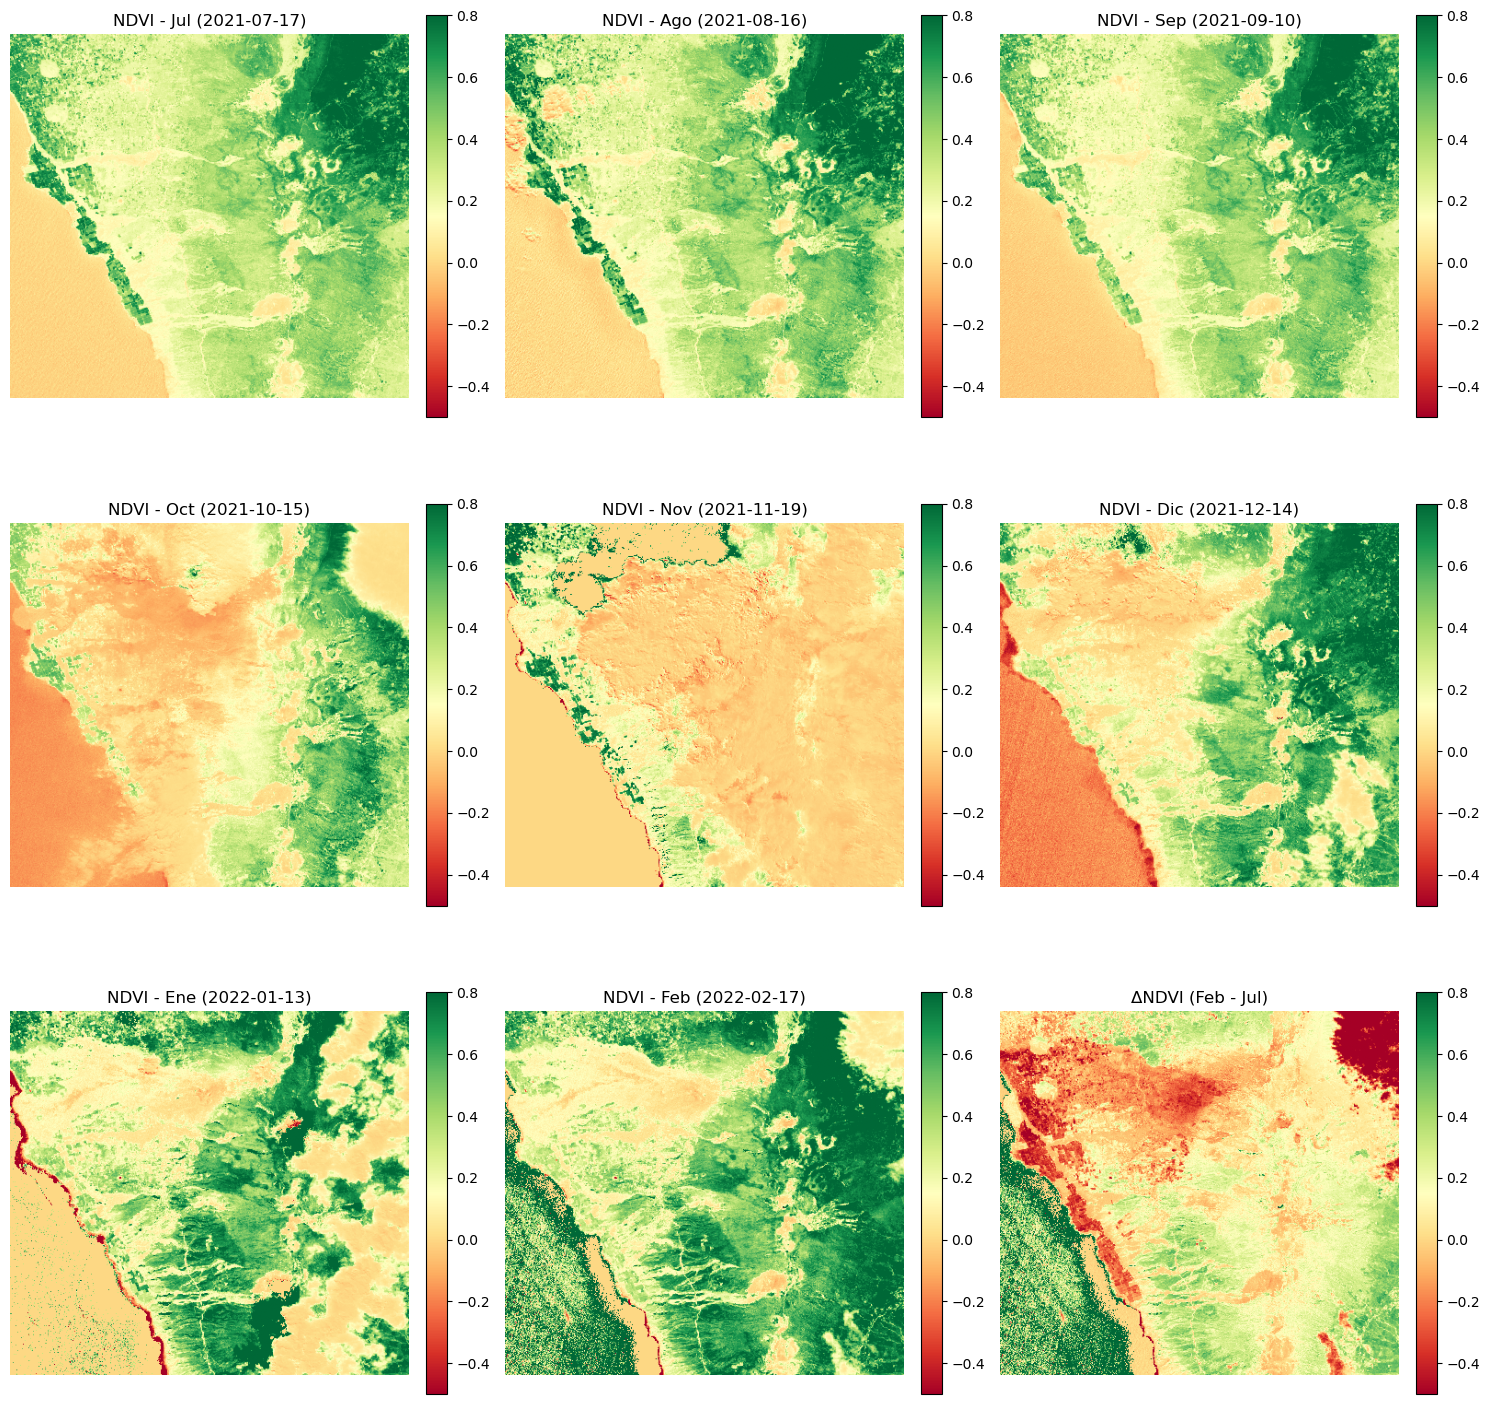

In [7]:
from sentinelhub import SentinelHubRequest, MimeType, DataCollection, bbox_to_dimensions
import numpy as np
import matplotlib.pyplot as plt
import os

# --- Crear carpeta de salida ---
os.makedirs("./data", exist_ok=True)

resolution = 30  # metros por píxel
size = bbox_to_dimensions(bbox, resolution=resolution)

# --- Función para obtener bandas rojo y NIR ---
def get_image(time_interval):
    request = SentinelHubRequest(
        data_folder="./data",
        evalscript="""
        //VERSION=3
        function setup() {
          return {
            input: ["B04", "B08"],
            output: { bands: 2, sampleType: "FLOAT32" }
          };
        }
        function evaluatePixel(sample) {
          return [sample.B04, sample.B08];
        }
        """,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.SENTINEL2_L2A,
                time_interval=time_interval,
                mosaicking_order='leastCC'
            )
        ],
        responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
        bbox=bbox,
        size=size,
        config=config
    )
    return request.get_data(save_data=True)[0]

# --- Descarga automática usando las mejores fechas detectadas ---
images = {}
for label, t in zip(
    ["Jul", "Ago", "Sep", "Oct", "Nov", "Dic", "Ene", "Feb"],
    [time_jul, time_aug, time_sep, time_oct, time_nov, time_dec, time_jan, time_feb]
):
    print(f"🛰️ Descargando imagen {label}...")
    img = get_image(t)
    b4, b8 = img[..., 0], img[..., 1]
    ndvi = (b8 - b4) / (b8 + b4 + 1e-6)
    images[label] = ndvi

# --- Calcular cambio entre julio y febrero ---
delta_ndvi = images["Feb"] - images["Jul"]

# --- Fechas exactas (para los títulos) ---
fechas = {
    "Jul": best_jul,
    "Ago": best_aug,
    "Sep": best_sep,
    "Oct": best_oct,
    "Nov": best_nov,
    "Dic": best_dec,
    "Ene": best_jan,
    "Feb": best_feb
}

# --- Plotear NDVI mensual + ΔNDVI ---
fig, axs = plt.subplots(3, 3, figsize=(15, 15))

titles = [
    f"NDVI - Jul ({fechas['Jul']})",
    f"NDVI - Ago ({fechas['Ago']})",
    f"NDVI - Sep ({fechas['Sep']})",
    f"NDVI - Oct ({fechas['Oct']})",
    f"NDVI - Nov ({fechas['Nov']})",
    f"NDVI - Dic ({fechas['Dic']})",
    f"NDVI - Ene ({fechas['Ene']})",
    f"NDVI - Feb ({fechas['Feb']})",
    "ΔNDVI (Feb - Jul)"
]

imgs = [
    images["Jul"],
    images["Ago"],
    images["Sep"],
    images["Oct"],
    images["Nov"],
    images["Dic"],
    images["Ene"],
    images["Feb"],
    delta_ndvi
]

for ax, img, title in zip(axs.ravel(), imgs, titles):
    im = ax.imshow(img, cmap="RdYlGn", vmin=-0.5, vmax=0.8)
    ax.set_title(title)
    ax.axis("off")
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()